In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # y축의 눈금을 정수만 표기
%matplotlib inline

# 새로운 라이브러리
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 위아래중 하나 선택
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.utils import nsdiffs

In [2]:
df = pd.read_pickle('/Users/joseph/git/DS_Capstone/weekday_day_pratice.pkl')
weather_data = pd.read_csv('/Users/joseph/git/DS_Capstone/weather_df.csv',encoding='cp949')

In [3]:
print(df.columns) # 컬럼: 대여소 3~8번까지의 2022.01.03~2022.12.30까지의 대여 데이터

Index(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
       '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14',
       ...
       '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
       '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30'],
      dtype='object', length=260)


In [4]:
# 데이터 전처리: 날짜를 인덱스로 설정하고 행과 열을 바꿉니다.
df_transposed = df.transpose()

# 인덱스를 날짜로 변환
df_transposed.index = pd.to_datetime(df_transposed.index)

# 인덱스가 제대로 날짜로 변환되었는지 확인
is_all_datetime_index = isinstance(df_transposed.index, pd.DatetimeIndex)
print("모든 인덱스가 datetime 객체인가요?:", is_all_datetime_index)

# 데이터프레임 확인
df_transposed.head(20)

모든 인덱스가 datetime 객체인가요?: True


,3,4,5,6,7,8
2022-01-03,35,35,27,15,24,22
2022-01-04,43,24,23,21,27,25
2022-01-05,39,22,30,16,16,27
2022-01-06,40,36,24,18,20,26
2022-01-07,45,27,32,24,26,29
2022-01-10,33,28,23,16,21,25
2022-01-11,27,18,27,8,13,15
2022-01-12,40,24,16,15,14,20
2022-01-13,38,22,18,8,18,23
2022-01-14,37,17,31,19,16,25


In [6]:
# 날씨 데이터셋의 NA값 개수 출력: 1개
print(weather_data.isna().sum())
# NA가 있는 행 출력
na_rows = weather_data[weather_data.isna().any(axis=1)]
print(na_rows)

# NA 열 제거: 전체 260개중 하루를 제거하는 것은 0.38%를 제거하는 것 
# -> 대여량 데이터는 날씨 데이터와 merge하면서 자동으로 제거됨(왜냐하면 inner join)
weather_data = weather_data[weather_data['일시'] != '2022-08-08']

# # NA값이 잘 제거되었는지 확인: 8월5일~8월10일까지 출력
print(weather_data[(weather_data['일시'] >= '2022-08-05') & (weather_data['일시'] <= '2022-08-10')])

Unnamed: 0    0
일시            0
강수량(mm)       0
최고기온(℃)       0
평균기온(℃)       0
최저기온(℃)       1
일교차           1
평균습도(%rh)     0
일조율(%)        0
평균풍속(m/s)     0
최대풍속(m/s)     0
dtype: int64
     Unnamed: 0          일시  강수량(mm)  최고기온(℃)  평균기온(℃)  최저기온(℃)  일교차   
219         219  2022-08-08    129.6     28.4     26.8      NaN  NaN  \

     평균습도(%rh)  일조율(%)  평균풍속(m/s)  최대풍속(m/s)  
219       91.6     0.0        3.3        8.6  


In [10]:
# weather_data의 날짜 열을 주중데이터셋의 날짜 형식인 datetime으로 통일
weather_data['일시'] = pd.to_datetime(weather_data['일시'])
# 일시'열을 인덱스로 설정: 동일한 인덱스로 데이터프레임 병합
weather_data.set_index('일시', inplace=True)
weather_data.index.name = None
 
# 불필요한 열 제거
weather_data.drop('Unnamed: 0', axis=1, inplace=True)

# 날짜 인덱스로 데이터 병합 
merged_data = df_transposed.join(weather_data, how='inner')

# 병합된 데이터 확인
merged_data.head()

,3,4,5,6,7,8,강수량(mm),최고기온(℃),평균기온(℃),최저기온(℃),일교차,평균습도(%rh),일조율(%),평균풍속(m/s),최대풍속(m/s)
2022-01-03,35,35,27,15,24,22,0.0,2.5,-1.9,-8.0,10.5,58.3,80.4,1.8,4.1
2022-01-04,43,24,23,21,27,25,0.0,1.0,-2.5,-5.6,6.6,51.8,92.8,2.4,4.2
2022-01-05,39,22,30,16,16,27,0.0,1.9,-2.8,-7.8,9.7,47.6,19.6,1.7,2.9
2022-01-06,40,36,24,18,20,26,0.0,3.3,-2.2,-5.9,9.2,47.1,93.8,2.3,4.6
2022-01-07,45,27,32,24,26,29,0.0,4.5,-1.6,-5.9,10.4,47.1,93.8,1.5,3.0


In [25]:
# 날씨 관련 변수의 열을 추가 피쳐로 선택
feature_variables = merged_data.columns[6:] # 7번째 열부터 날씨 관련 피쳐

# 피쳐 선택 (날씨 관련 변수)
features = merged_data[feature_variables]
features

,강수량(mm),최고기온(℃),평균기온(℃),최저기온(℃),일교차,평균습도(%rh),일조율(%),평균풍속(m/s),최대풍속(m/s)
2022-01-03,0.0,2.5,-1.9,-8.0,10.5,58.3,80.4,1.8,4.1
2022-01-04,0.0,1.0,-2.5,-5.6,6.6,51.8,92.8,2.4,4.2
2022-01-05,0.0,1.9,-2.8,-7.8,9.7,47.6,19.6,1.7,2.9
2022-01-06,0.0,3.3,-2.2,-5.9,9.2,47.1,93.8,2.3,4.6
2022-01-07,0.0,4.5,-1.6,-5.9,10.4,47.1,93.8,1.5,3.0
...,...,...,...,...,...,...,...,...,...
2022-12-26,0.0,1.7,-3.9,-7.9,9.6,68.4,79.2,1.4,2.8
2022-12-27,0.0,3.3,-2.6,-7.3,10.6,69.8,91.7,1.8,3.2
2022-12-28,0.1,0.1,-3.3,-6.0,6.1,58.1,90.6,2.5,4.9
2022-12-29,0.0,2.1,-2.9,-7.8,9.9,56.3,93.8,1.7,3.4


### 2. Augmented Dickey-Fuller(ADF) Test 수행  
H0:시계열 데이터가 단위 루트를 가지며, 정상성이 없다.  
H1:시계열 데이터가 단위 루트를 가지지 않으며, 정상성이 있다.  


<결과>  
아래 히스토그램은 각 대여소별 시계열 데이터에 대해 수행된 Augmented Dickey-Fuller (ADF) 테스트의 p-value 분포를 보여줍니다. 빨간 점선은 0.05의 유의 수준을 나타냅니다. 그러나 이 결과에서 모든 대여소의 시계열이 유의수준보다 높은 p-value를 가지므로, 모든 대여소의 시계열 데이터는 정상성을 만족하지 않습니다. ---> """차분이 필요"""  


정상성(Stationarity): 시계열 데이터의 특정 통계적 특성(평균, 분산 등)이 시간에 따라 일정하다는 속성

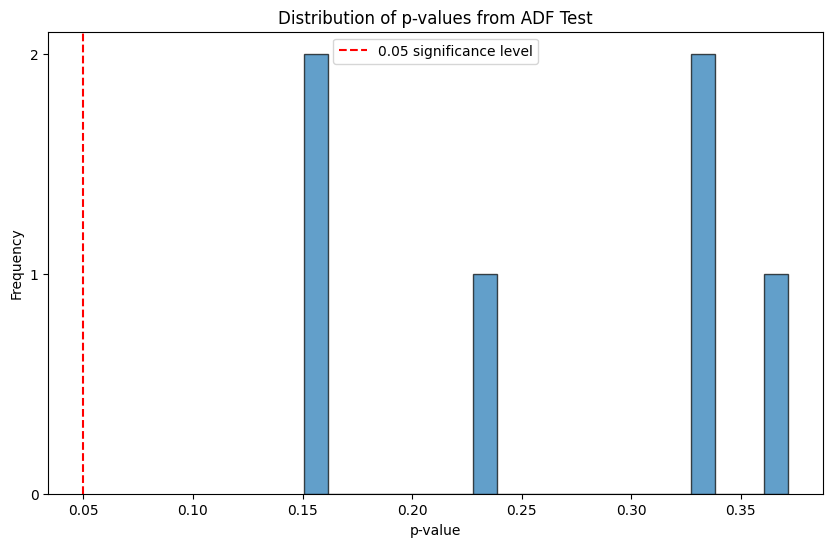

전체 개수: 6, 정상성을 만족하는 시계열의 수: 0개


In [7]:
# 각 대여소별로 ADF 테스트 수행(날씨 피쳐는 제외하고 대여량 열만 진행)
adf_results = []
for col in df_transposed.columns:
    adf_test = adfuller(df_transposed[col])
    adf_results.append(adf_test[1])  # p-value 저장

# p-value의 분포 플롯
plt.figure(figsize=(10,6))
plt.hist(adf_results, bins=20, edgecolor='k', alpha=0.7) # bins=20: 최대 20개의 막대
plt.title('Distribution of p-values from ADF Test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(x=0.05, color='r', linestyle='--', label='0.05 significance level')
plt.legend()

# y축 눈금을 정수만 표시
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# 정상성을 만족하는 시계열의 수: 0개.
stationary_series_count = sum(p_value < 0.05 for p_value in adf_results)
print(f"전체 개수: {len(adf_results)}, 정상성을 만족하는 시계열의 수: {stationary_series_count}개")

### 3. 정상성 얻기
정상성을 얻기 위한 방법으로 regression approach,평활(smoothing), 차분이 있다.  

1) 정상성을 얻기 위한 차분의 종류  

    1-1) 일반 차분(1차 차분)  
        - KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test:  
            귀무 가설(H0): 시계열이 정상성입니다.  
        - ADF(Augmented Dickey-Fuller Test):  
            귀무 가설 (H0): 시계열에 단위 루트가 있습니다(비정상성).  
        - PP(Phillips-Perron Test):  
            귀무 가설 (H0): 시계열에 단위 루트가 있습니다(비정상성).   
    1-2) 계절 차분  
        - OCSB 검정  
        - Canova-Hansen 검정

2) 정상성에 필요한 차분 차수 결정 방법  
    차분을 하고 테스트를 하여 최초로 귀무가설을 기각 or 받아들일 때까지 반복  
    2-1) 일반 차분  

    2-2) 계절 차분  
      

In [14]:
# 각 컬럼에 대해 일반 차분 차수와 계절 차분 차수를 결정(여기서는 날씨 피쳐를 제외한 대여량만 진행)
# 1) 일반 차분
kpss_diffs = df_transposed.apply(lambda x: ndiffs(x, test='kpss'), axis=0)
adf_diffs = df_transposed.apply(lambda x: ndiffs(x, test='adf'), axis=0)
pp_diffs = df_transposed.apply(lambda x: ndiffs(x, test='pp'), axis=0)

# 2) 계절 차분
# OCSB(Osborn, Chui, Smith, and Birchenhall) 검정
oscb_seasonal_diffs = df_transposed.apply(lambda x: nsdiffs(x, m=12, test='ocsb'), axis=0) # m:12개월
# Canova-Hansen 검정
ch_seasonal_diffs = df_transposed.apply(lambda x: nsdiffs(x, m=12, test='ch'), axis=0)

# 결과 출력: 유일한 값의 빈도 계산
# 일차 차분
print("Differencing order:")
print("KPSS Test:")
print(kpss_diffs.value_counts())
print("\nADF Test:")
print(adf_diffs.value_counts())
print("\nPP Test:")
print(pp_diffs.value_counts())
print("-" * 50)
# 계절차분
print("Seasonal differencing order:")
print("OCSB Test:")
print(oscb_seasonal_diffs.value_counts())
print("\nCanova-Hansen Test:")
print(ch_seasonal_diffs.value_counts())

Differencing order:
KPSS Test:
1    6
Name: count, dtype: int64

ADF Test:
1    6
Name: count, dtype: int64

PP Test:
0    6
Name: count, dtype: int64
--------------------------------------------------
Seasonal differencing order:
OCSB Test:
0    6
Name: count, dtype: int64

Canova-Hansen Test:
0    6
Name: count, dtype: int64


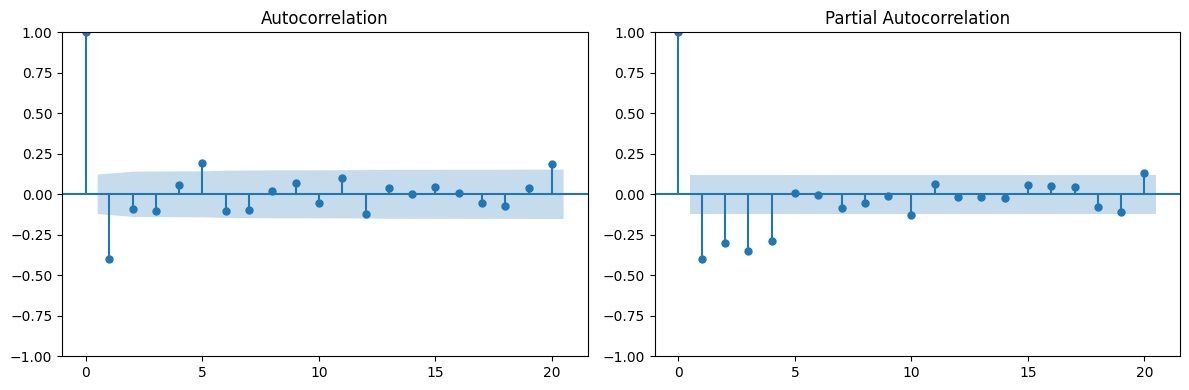

In [15]:
# 차분
df_diff = df_transposed.diff().dropna()

# 차분된 데이터의 첫 번째 시리즈에 대해 ACF 및 PACF 플롯 작성
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 3번 대여소의 ACF plot -> MA order(q) 결정
# q+1에서 급격한 감소가 나타나는 시차 지점,  q=1 or 2  --> 두개가 상관 없다면 차원을 줄이기 위해 더 작은 값인 1로 설정
plot_acf(df_diff.iloc[:, 0], lags=20, ax=ax[0]) 

# 3번 대여소의 PACF plot -> AR order(p) 결정
# p+1에서 급격한 감소가 나타나는 시차 시점,  p=2
plot_pacf(df_diff.iloc[:, 0], lags=20, ax=ax[1])

plt.tight_layout()
plt.show()

In [16]:
# 차분을 한 뒤 검정을 통해 각 검정을 통과하는지 확인 
# 1) 일반 차분
kpss_diffs = df_diff.apply(lambda x: ndiffs(x, test='kpss'), axis=0)
adf_diffs = df_diff.apply(lambda x: ndiffs(x, test='adf'), axis=0)
pp_diffs = df_diff.apply(lambda x: ndiffs(x, test='pp'), axis=0)

# 2) 계절 차분
# OCSB 검정
oscb_seasonal_diffs = df_diff.apply(lambda x: nsdiffs(x, m=12, test='ocsb'), axis=0) # m:12개월
# Canova-Hansen 검정
ch_seasonal_diffs = df_diff.apply(lambda x: nsdiffs(x, m=12, test='ch'), axis=0)


# 결과 출력: 유일한 값의 빈도 계산
# 일차 차분
print("Differencing order:")
print("KPSS Test:")
print(kpss_diffs.value_counts())
print("\nADF Test:")
print(adf_diffs.value_counts())
print("\nPP Test:")
print(pp_diffs.value_counts())
print("-" * 50)
# 계절차분
print("Seasonal differencing order:")
print("OCSB Test:")
print(oscb_seasonal_diffs.value_counts())
print("\nCanova-Hansen Test:")
print(ch_seasonal_diffs.value_counts())

Differencing order:
KPSS Test:
0    6
Name: count, dtype: int64

ADF Test:
0    6
Name: count, dtype: int64

PP Test:
0    6
Name: count, dtype: int64
--------------------------------------------------
Seasonal differencing order:
OCSB Test:
0    6
Name: count, dtype: int64

Canova-Hansen Test:
0    6
Name: count, dtype: int64


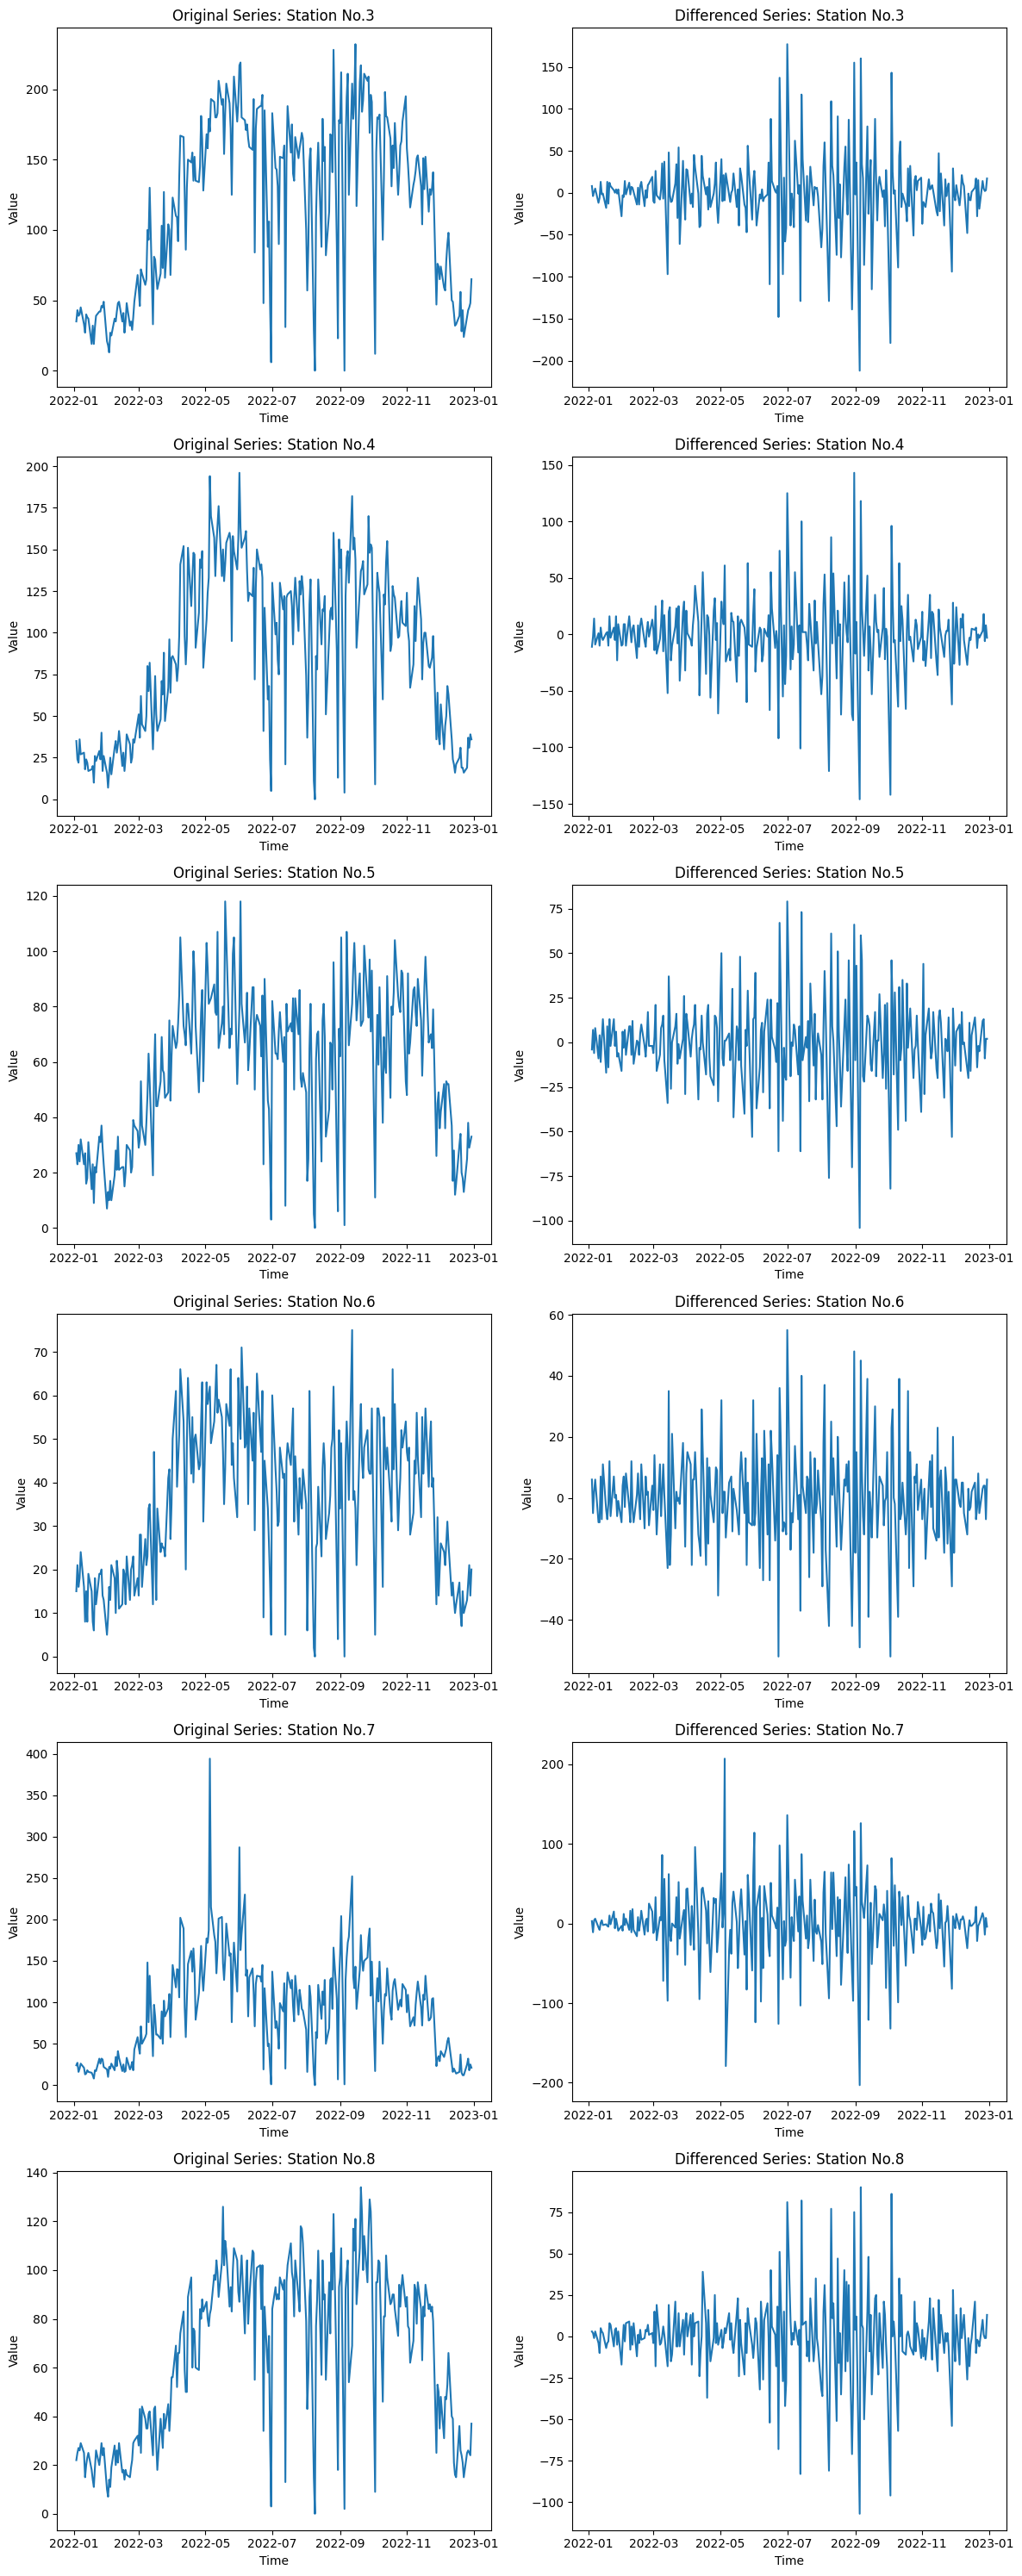

In [20]:
# 차분 전과 차분 후의 차이
fig, axes = plt.subplots(len(df_transposed.columns), 2, figsize=(12, 5 * len(df_transposed.columns)))

for i, column in enumerate(df_transposed.columns):
    # 원래의 시계열 데이터 플롯
    axes[i, 0].plot(df_transposed.index, df_transposed[column])
    axes[i, 0].set_title(f'Original Series: Station No.{column}')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Value')

    # 차분된 시계열 데이터 플롯
    axes[i, 1].plot(df_diff.index, df_diff[column])
    axes[i, 1].set_title(f'Differenced Series: Station No.{column}')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Value')

# 그래프 표시
plt.tight_layout()
plt.show()

### 모델 학습

#### 새로운 데이터로 진행

In [5]:
# 데이터 불러오기
bycycle_year_path = '/Users/joseph/git/DS_Capstone/Sample_Model/Data' + '/weekday_re_df_1021.pkl'

df = pd.read_pickle(bycycle_year_path)

# df의 열 이름을 날짜 형식으로 변환
df.columns = pd.to_datetime(df.columns)

# 데이터 전처리: 날짜를 인덱스로 설정하고 행과 열을 바꿉니다.
df = df.transpose()

# df_transposed의 인덱스를 열로 변환하고 이름을 '일시'로 지정
df = df.reset_index().rename(columns={'index': '일시'})
df

,일시,3,4,5,6,7,8,9,10,11,...,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755
0,2022-01-03,35,35,27,15,24,22,25,10,15,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-04,43,24,23,21,27,25,25,14,14,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-05,39,22,30,16,16,27,26,12,11,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-06,40,36,24,18,20,26,23,14,16,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-07,45,27,32,24,26,29,25,11,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-12-26,38,19,25,13,25,25,33,15,7,...,24,50,42,25,66,16,14,8,27,3
256,2022-12-27,43,37,38,17,32,26,31,19,7,...,26,68,33,22,79,32,15,11,24,1
257,2022-12-28,45,31,29,21,18,25,27,16,9,...,27,67,22,25,62,20,15,6,20,7
258,2022-12-29,48,39,31,14,25,24,31,14,12,...,32,80,19,33,72,27,11,4,24,3


In [6]:
weather_df = pd.read_csv('/Users/joseph/git/DS_Capstone/weather_df.csv',encoding='cp949')
weather_df = weather_df.drop('Unnamed: 0', axis=1)
weather_df['일시'] = pd.to_datetime(weather_df['일시'])
weather_df

,일시,강수량(mm),최고기온(℃),평균기온(℃),최저기온(℃),일교차,평균습도(%rh),일조율(%),평균풍속(m/s),최대풍속(m/s)
0,2022-01-01,0.0,2.3,-4.3,-10.2,12.5,46.3,93.8,1.5,2.8
1,2022-01-02,0.3,3.0,-1.3,-5.2,8.2,57.9,56.3,2.3,4.6
2,2022-01-03,0.0,2.5,-1.9,-8.0,10.5,58.3,80.4,1.8,4.1
3,2022-01-04,0.0,1.0,-2.5,-5.6,6.6,51.8,92.8,2.4,4.2
4,2022-01-05,0.0,1.9,-2.8,-7.8,9.7,47.6,19.6,1.7,2.9
...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,0.0,3.3,-2.6,-7.3,10.6,69.8,91.7,1.8,3.2
361,2022-12-28,0.1,0.1,-3.3,-6.0,6.1,58.1,90.6,2.5,4.9
362,2022-12-29,0.0,2.1,-2.9,-7.8,9.9,56.3,93.8,1.7,3.4
363,2022-12-30,0.0,2.3,-1.8,-4.4,6.7,65.6,82.3,1.9,4.6


In [7]:
# 데이터프레임에서 결측치가 있는 행만 출력
print(weather_df[weather_df.isna().any(axis=1)])
print(df[df.isna().any(axis=1)])

# 결측치 제거
df = df.dropna()
weather_df = weather_df.dropna()

            일시  강수량(mm)  최고기온(℃)  평균기온(℃)  최저기온(℃)  일교차  평균습도(%rh)  일조율(%)   
219 2022-08-08    129.6     28.4     26.8      NaN  NaN       91.6     0.0  \

     평균풍속(m/s)  최대풍속(m/s)  
219        3.3        8.6  
Empty DataFrame
Columns: [일시, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, ...]
Index: []

[0 rows x 2710 columns]


In [8]:
# '일시' 열을 기준으로 공통된 행만 필터링
common_dates = weather_df['일시'].isin(df['일시'])
weather_df = weather_df[common_dates]

common_dates = df['일시'].isin(weather_df['일시'])
df = df[common_dates]

# 결과 확인
print(weather_df.shape)
print(df.shape)

(259, 10)
(259, 2710)


### Sliding window

In [9]:
# 3~8월까지 train, 9월 test
x_train_df = weather_df[(weather_df['일시'] >= '2022-03-01') & (weather_df['일시'] < '2022-09-01')]
y_train_df = df[(df['일시'] >= '2022-03-01') & (df['일시'] < '2022-09-01')]

x_test_df = weather_df[(weather_df['일시'] >= '2022-09-01') & (weather_df['일시'] < '2022-10-01')]
y_test_df = df[(df['일시'] >= '2022-09-01') & (df['일시'] < '2022-10-01')]

In [10]:
print(y_train_df.shape)
print(x_train_df.shape)
print(y_test_df.shape)
x_test_df.shape

(131, 2710)
(131, 10)
(22, 2710)


(22, 10)

In [11]:
# 데이터셋 병합 함수
def combine_datasets(x_df, y_df):
    # '일시' 열을 기준으로 두 데이터셋을 합칩니다
    combined_df = pd.merge(x_df, y_df, on='일시')
    return combined_df

# 훈련 및 테스트 데이터셋 생성
train_df = combine_datasets(x_train_df, y_train_df)
test_df = combine_datasets(x_test_df, y_test_df)

In [12]:
# 슬라이딩 윈도우 방식으로 데이터셋 생성 함수
def create_dataset(x, y, window_length, forecast_length):
    X, y_new = [], []
    for i in range(len(x) - window_length - forecast_length + 1):
        X.append(x.iloc[i:(i + window_length)].values.flatten())
        y_new.append(y.iloc[(i + window_length):(i + window_length + forecast_length)].values.flatten())
    return np.array(X), np.array(y_new)

In [13]:
# 슬라이딩 윈도우 적용 및 데이터셋 준비
window_length = 3
forecast_length = 1

In [14]:
# 슬리이딩 윈도우를 적용한 train, test 셋 생성
X_train, y_train = create_dataset(train_df.iloc[:, :-2709], train_df.iloc[:, -2709:], window_length, forecast_length)
X_test, y_test = create_dataset(test_df.iloc[:, :-2709], test_df.iloc[:, -2709:], window_length, forecast_length)

In [15]:
### 모델에 넣을 때 time stamp 제거: XGBoost는 numeric data만 사용 가능
# X_train 배열에서 Timestamp 객체 제거
new_X_train = np.array([np.array([x for x in row if not isinstance(x, pd.Timestamp)]) for row in X_train])
new_X_train

array([[ 2.3,  9.7,  5.8, ..., 93. ,  2.1,  4.7],
       [ 0. ,  8.8,  3.5, ..., 32.2,  3.6,  8.8],
       [ 0. , 12.4,  5.8, ..., 60.3,  2. ,  3.9],
       ...,
       [ 0. , 27.9, 24.8, ..., 59.1,  2.4,  5.1],
       [ 1.6, 24. , 22.2, ...,  0. ,  2.3,  3.9],
       [ 0. , 28.4, 23.8, ...,  0. ,  2.6,  4.1]])

In [65]:
## 위에서 train, test셋이 sliding window로 적용된 것을 확인했다면, 이제는 XGBoost 모델에 넣기 위해서
# Timestamp 형식을 제거하여 numeric feature로 변환
 
# NumPy 배열을 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test)

# Timestamp 타입의 열 제거
X_test_df = X_test_df.select_dtypes(exclude=['datetime64[ns]'])

# DataFrame을 다시 NumPy 배열로 변환
new_X_test = X_test_df.to_numpy()
new_X_test

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [63]:
# y_pred_array의 크기를 y_test와 동일하게 설정
y_pred_array = np.zeros(y_test.shape)

# new_X_train을 사용하여 각 대여소별로 SARIMAX 모델 적용
for i in range(new_X_train.shape[1]):  # new_X_train.shape[1]은 대여소의 수를 나타냄
    # 대여소별 시계열 데이터
    ts_data = new_X_train[:, i]

    # SARIMAX 모델 정의
    model = SARIMAX(ts_data, order=(2, 1, 1) , seasonal_order=(2, 1, 1, 12)) #12개월

    # 모델 훈련
    model_fit = model.fit(disp=False)

    # 테스트 데이터에 대한 예측 수행
    y_pred = model_fit.forecast(steps=len(new_X_test))

    # 예측 결과를 배열에 저장
    y_pred_array[:, i] = y_pred

In [64]:
# 모델 평가
# 각 대여소별 RMSE 계산
rmse_per_station = np.sqrt(np.mean(np.square(y_test - y_pred_array), axis=0))

# 전체 평균 RMSE 계산
average_rmse = np.mean(rmse_per_station)
print("Average RMSE across all stations: ", average_rmse)